## Lnphi continuity in a_mix, b_mix

Plot lnphi vs x_c1

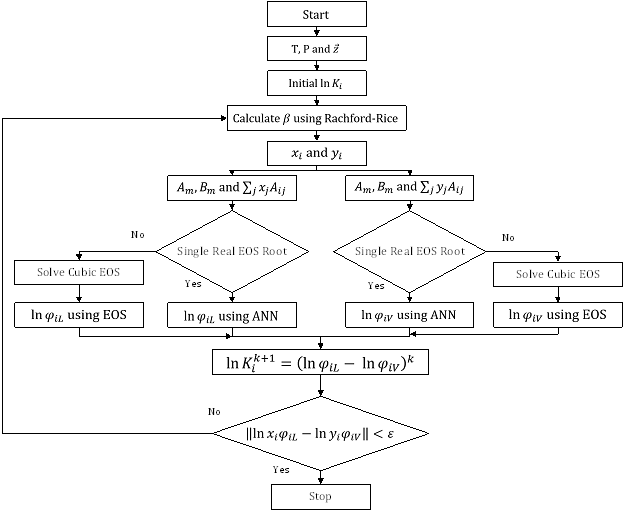

In [1]:
import pandas as pd
import tensorflow as tf
import pickle
from Stability_and_flash import pr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc


In [2]:
# Load model   
loaded_model = tf.keras.models.load_model(
    r'C:\Users\win7\Desktop\logs\logs\scalars\nC4-nC10_650K__100_3_20_80_20200817-164056')
loaded_model.summary()

# Load pipeline
with open(
    r'C:\Users\win7\Desktop\logs\logs\scalars\nC4-nC10_650K__100_3_20_80_20200817-164056\full_pipeline_nC4-nC10_650K__100_3_20_80_.pkl',
    'rb') as f:
    attr_full_pipeline = pickle.load(f)
    label_full_pipeline = pickle.load(f)

# Instantiate class
pr = pr()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                100       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________


In [3]:
label_full_pipeline

Pipeline(steps=[('label minmax scaler', MinMaxScaler())])

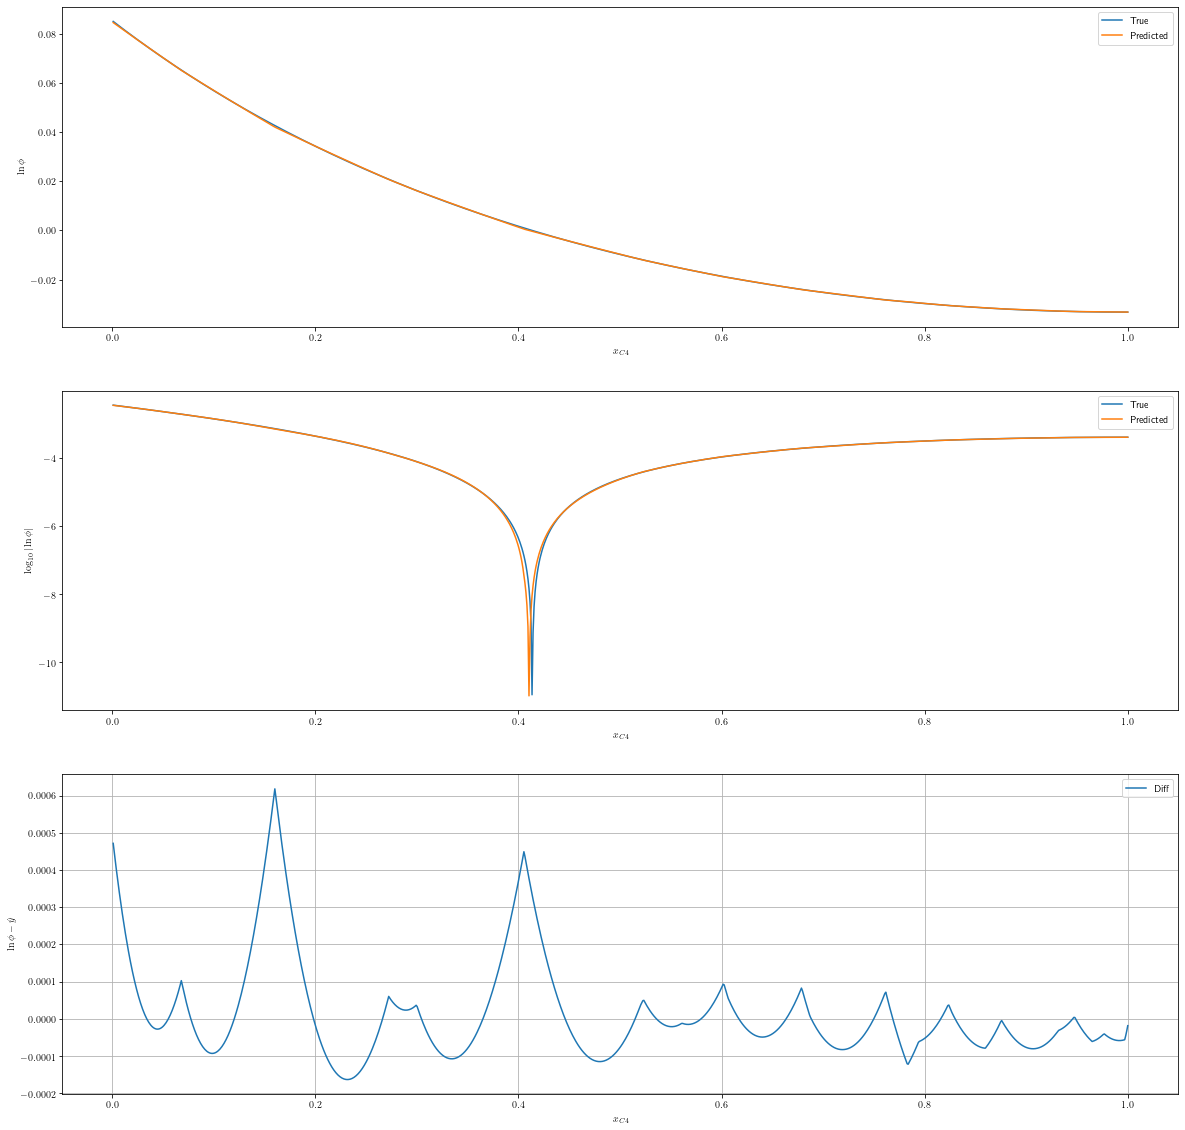

In [8]:
# INPUTS
T = 650  # [K]
P = 14.6  # [bar]

'''# C1-C10
w = np.array([0.008, 0.49])
z = np.array([0.8, 0.2])
Pc = np.array([46.0, 21.1]) #[bar]
Tc = np.array([190.7, 617.6]) #[K]
BIP = np.zeros([2,2])'''

# nC4-C10
w = np.array([0.193, 0.49])
z = np.array([0.8, 0.2])
Pc = np.array([37.997, 21.1])  # [bar]
Tc = np.array([425.2, 617.6])  # [K]
BIP = np.zeros([2, 2])

NRtol = 1E-12
NRmaxit = 100  # I think 10 is enough
SStol = 1E-10  #
tolSSSA = 1E-10
SSmaxit = 500  # 1000000 # 1E6 might crash my computer.
TolRR = 1E-10
TolXz = 1E-8
itSSSAmax = 1E6

# More global constants
Tr = T / Tc
Pr = P / Pc

Nc = len(z)

phase_num = 1
row_index = 0

#####################################################################################
# Instantiate class
# pr = pr()

# Parameters independent of composition placed out of loop.
# Used in either stability analysis or 2-phase PT flash.

# Get all K-values from Wilson
K = pr.wilson_corr(Pr, Tr, w)
ln_K = np.log(K)

# Get all ai, bi values
a_i, b_i = pr.aibi(P, T, w, Pr, Tr, Pc, Tc)

# Get Vw mixing, part with BIPs and square roots
Am = pr.Vw(Nc, a_i, BIP)

#############
G_R = []
G_R2 = []
x_1 = []
x_1_2 = []
x_1_3 = []
lnphi_x1 = []
lnphi_x2 = []
lnphi_x1_2 = []
lnphi_x2_2 = []
a_mix_1 = []
b_mix_1 = []
sum_xjAij_1 = []
G_R_IM = []
X = []
y = []
y_predicted = []
diff = []
for z[0] in np.linspace(0, 1, 1000):
    if z[0] == 0:
        continue
    #print(z[0])
    z[1] = 1 - z[0]
    sum_xiAij = pr.sum_a_interations(Nc, z, Am)
    a_mix = pr.am(z, sum_xiAij)
    b_mix = pr.bm(z, b_i)

    # All EOS variables defined, solve EOS
    Z = pr.Z_roots_calc(a_mix, b_mix)

    # If not single real positive root, get ln_phi and root which correspond to lowest Gibbs energy
    if len(Z) > 1 and min(Z) > 0:
        print('Not single real positive root at x_1 = {}, Z = {}'.format(z[0], Z))
        # Calc both lnphi
        Zmin = np.min(Z)
        Zmax = np.max(Z)

        ln_phi_z, Z = pr.checkG(b_i, a_mix, b_mix, sum_xiAij, Z, z)
        d = ln_phi_z + np.log(z)
        G_R.append(np.dot(d, z))
        x_1.append(z[0])

        lnphi_x1.append(ln_phi_z[0])
        lnphi_x2.append(ln_phi_z[1])

        # Plot higher G root as dotted line
        if Z == Zmin:
            ln_phi_max = pr.ln_phi_calc(b_i, a_mix, b_mix, sum_xiAij, Zmax)
            d1 = ln_phi_max + np.log(z)
            G_R2.append(np.dot(d1, z))
            x_1_2.append(z[0])

            lnphi_x1_2.append(ln_phi_max[0])
            lnphi_x2_2.append(ln_phi_max[1])
        elif Z == Zmax and Zmin > 0:
            ln_phi_min = pr.ln_phi_calc(b_i, a_mix, b_mix, sum_xiAij, Zmin)
            d1 = ln_phi_min + np.log(z)
            G_R2.append(np.dot(d1, z))
            x_1_2.append(z[0])

            lnphi_x1_2.append(ln_phi_min[0])
            lnphi_x2_2.append(ln_phi_min[1])
    else:
        # Get true lnphi
        ln_phi_z = pr.ln_phi_calc(b_i, a_mix, b_mix, sum_xiAij, Z)
        lnphi = ln_phi_z[0]
        # Store true lnphi
        X.append(z[0])
        y.append(ln_phi_z[0])
        # Get prediction
        X_prepared = pd.DataFrame(np.array([a_mix, b_mix, b_i[0], sum_xiAij[0]])).T
        X_prepared.columns = ['a_mix', 'b_mix', 'b_i', 'sum']
        X_prepared = attr_full_pipeline.transform(X_prepared)
        y_hat = loaded_model.predict(X_prepared)  # [0,0]
        y_hat = label_full_pipeline.inverse_transform(y_hat)[0, 0]
        # Store prediction
        y_predicted.append(y_hat)
        # Take log abs difference
        diff.append(lnphi - y_hat)
        
plt.rc('text', usetex=True)

fig = plt.figure(figsize=(20, 20))
ax3 = fig.add_subplot(311)
ax3.plot(X, y, label='True')
ax3.plot(X, y_predicted, label='Predicted')
ax3.set_ylabel(r'$\ln\phi$')
ax3.set_xlabel(r'$x_{C4}$')
ax3.legend()

ax = fig.add_subplot(312)
ax.plot(X, np.log(np.abs(y)), label='True')
ax.plot(X, np.log(np.abs(y_predicted)), label='Predicted')
ax.set_ylabel(r'$\log_{10}|\ln\phi|$')
ax.set_xlabel(r'$x_{C4}$')
ax.legend()

ax2 = fig.add_subplot(313)
ax2.plot(X, diff, label='Diff')
# ax2.set_title('Log abs diff')
ax2.set_ylabel(r'$\ln\phi-\hat{y}$')
ax2.set_xlabel(r'$x_{C4}$')
ax2.legend()
ax2.grid()

plt.show()
